In [1]:
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from datetime import datetime, timedelta
import pandas as pd

# Authenticate with NASA Earthdata
earthaccess.login()

In [2]:
# Open the PACE OCI L3b granule
granule = earthaccess.open(
    granules=["https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250804.L3m.DAY.FLH.V3_1.nflh.0p1deg.nc"]
)

# Open the dataset
ds = xr.open_dataset(granule[0])

# Print available variables to check what's in the dataset
print("Available variables:", list(ds.variables.keys()))
print("\nDataset structure:")
print(ds)

# Extract nFLH variable (adjust based on actual variable name)
# For L3b binned data, you may need to extract from specific groups
if 'nflh' in ds:
    nflh = ds['nflh']
elif 'chlor_a' in ds:  # If nflh not available, using chlor_a as example
    nflh = ds['chlor_a']
else:
    # Check for other possible variable names
    print("\nPlease specify the correct variable name from the list above")

# For L3b binned data, you'll need to work with bin indices
# Convert binned data to lat/lon grid
lat = ds['lat'].values if 'lat' in ds else None
lon = ds['lon'].values if 'lon' in ds else None

# If binned format, may need to grid the data first
if lat is None or lon is None:
    print("\nThis is binned L3b data. Converting to grid...")
    # Use bin_index to create grid
    bin_index = ds['bin_index'].values if 'bin_index' in ds else None

# Mask invalid values
nflh_masked = np.ma.masked_invalid(nflh)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Available variables: ['nflh', 'lat', 'lon', 'palette']

Dataset structure:
<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    nflh     (lat, lon) float32 26MB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20250804.L3m.DAY.FLH.V3_1.nfl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/

In [32]:
# open ocean sample
granule_name1 = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/sample/sample_granule_20250808T204353_new_chl.nc"
# open the granule using xarray
ds1 = xr.open_dataset(granule_name1)
lat1  = ds1['latitude'].values
lon1  = ds1['longitude'].values
# print the corner of the lat and lon
lat1_corners = [lat1[0,0], lat1[0,-1], lat1[-1,0], lat1[-1,-1]]
lon1_corners = [lon1[0,0], lon1[0,-1], lon1[-1,0], lon1[-1,-1]]
print("Open ocean lat corners:", lat1_corners)
print("Open ocean lon corners:", lon1_corners)
# reorganize to the bounds
box1 = [
    [lon1_corners[0], lat1_corners[0]],
    [lon1_corners[1], lat1_corners[1]],
    [lon1_corners[3], lat1_corners[3]],
    [lon1_corners[2], lat1_corners[2]],
    [lon1_corners[0], lat1_corners[0]],
]
# close
ds1.close()

# coastal area sample
granule_name2 = "/home/zhe2/data/MyProjects/PACE_redSIF_PACE/sample/sample_granule_20240830T131442_new_chl.nc"
# open the granule using xarray
ds2 = xr.open_dataset(granule_name2)
lat2  = ds2['latitude'].values
lon2  = ds2['longitude'].values
# print the corner of the lat and lon
lat2_corners = [lat2[0,0], lat2[0,-1], lat2[-1,0], lat2[-1,-1]]
lon2_corners = [lon2[0,0], lon2[0,-1], lon2[-1,0], lon2[-1,-1]]
print("Coastal area lat corners:", lat2_corners)
print("Coastal area lon corners:", lon2_corners)
# reorganize to the bounds
box2 = [
    [lon2_corners[0], lat2_corners[0]],
    [lon2_corners[1], lat2_corners[1]],
    [lon2_corners[3], lat2_corners[3]],
    [lon2_corners[2], lat2_corners[2]],
    [lon2_corners[0], lat2_corners[0]],
]
# close
ds2.close()


Open ocean lat corners: [np.float32(-22.349102), np.float32(-17.12057), np.float32(-4.4498496), np.float32(0.5877362)]
Open ocean lon corners: [np.float32(-125.99131), np.float32(-100.584946), np.float32(-128.92), np.float32(-105.174965)]
Coastal area lat corners: [np.float32(46.337784), np.float32(52.64059), np.float32(61.33597), np.float32(70.21549)]
Coastal area lon corners: [np.float32(-31.067873), np.float32(5.3687453), np.float32(-49.90744), np.float32(8.346756)]


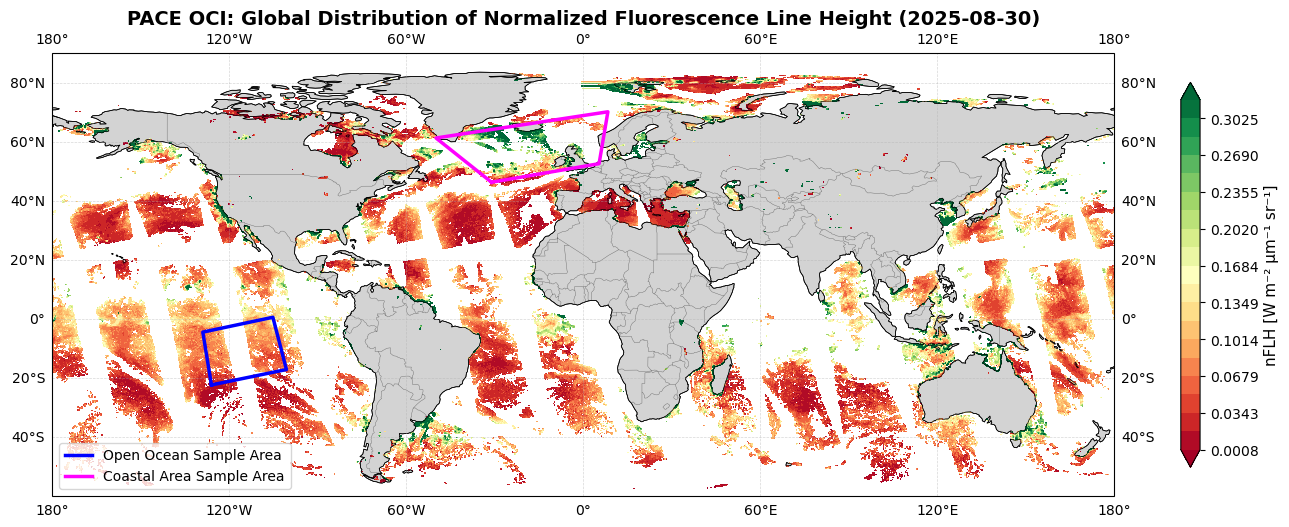

In [36]:
# Create figure with PlateCarree projection
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')

# Set global extent
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

# Plot nFLH data using contourf
levels = np.linspace(np.nanpercentile(nflh, 2), np.nanpercentile(nflh, 98), 20)
im = ax.contourf(lon, lat, nflh_masked, 
                 levels=levels,
                 transform=ccrs.PlateCarree(),
                 cmap='RdYlGn',
                 extend='both')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.5, extend='both')
cbar.set_label('nFLH [W m⁻² μm⁻¹ sr⁻¹]', 
               fontsize=11)

# draw box boundary for open ocean sample
box1_lon, box1_lat = zip(*box1)
ax.plot(box1_lon, box1_lat, color='blue', linewidth=2.5, 
        transform=ccrs.PlateCarree(), label='Open Ocean Sample Area')
ax.legend(loc='lower left', fontsize=10)
# coastal area sample

box2_lon, box2_lat = zip(*box2)
ax.plot(box2_lon, box2_lat, color='magenta', linewidth=2.5, 
        transform=ccrs.PlateCarree(), label='Coastal Area Sample Area')
ax.legend(loc='lower left', fontsize=10)

# Set title
plt.title('PACE OCI: Global Distribution of Normalized Fluorescence Line Height (2025-08-30)', # \n2025-08-30
          fontsize=14, fontweight='bold')

plt.tight_layout()

# Close dataset
ds.close()